In [1]:
import findspark
findspark.init()

import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark import sql, SparkConf, SparkContext
from pyspark.sql.functions import avg, col, to_date, lit
import ipywidgets as ipy
from IPython.display import display, clear_output
from ipywidgets import Output, VBox, widgets, interact

In [2]:
conf = SparkConf().setAppName("Read_CSV")
sc = SparkContext(conf=conf)
sqlContext = sql.SQLContext(sc)

dfPollution = sqlContext.read.csv("Luchtvervuiling.csv", header=True)

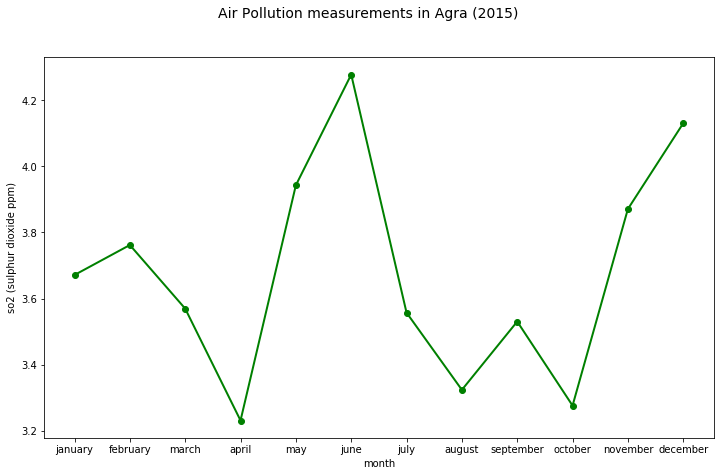

In [3]:
MONTHS = ['january','february','march','april','may','june','july','august','september','october','november','december']

#haal alle waarden uit date kolom met als doel alle verschillende jaren in een lijst te steken voor filter
date_rows = dfPollution.select(to_date(dfPollution.date).alias('to_date')).collect()
years = []
for row in date_rows:
    try:
        if row.to_date.year not in years:
            years.append(row.to_date.year)
    except:
        pass
years.sort(reverse=True)

#haal aalle waarden uit location kolom met als doel alle verschillende locations in een lijst te steken voor filter
location_rows = dfPollution.select("location").distinct().collect()
locations = [str(row['location']) for row in location_rows]
locations.sort()


cityFilter = widgets.Dropdown(
    options = locations,
    value = locations[0],
    description = 'Location:',
    disabled = False,
)
yearFilter = widgets.Dropdown(
    options = years,
    value = years[0],
    description = 'Year:',
    disabled = False,
)
display(widgets.HBox((cityFilter, yearFilter)))

def update_plot():
    x_axis = MONTHS
    y_axis = []
    #per maand het gemiddelde so2 berekenen a.d.h.v. filters voor het jaar en locatie
    for i in range(1,13):
        if i < 10:
            month = "0" + str(i)
        else:
            month = str(i)
        try:
            month_rows = dfPollution.filter((col("date").between(str(yearFilter.value) + "-" + month + "-01", str(yearFilter.value) + "-" + month + "-31")) & (col("location") == cityFilter.value) & (col("so2") != 'NA'))
            if month_rows.count() > 0:
                month_so2_rows = month_rows.select("so2").collect()
                try:
                    month_so2 = [int(row['so2']) for row in month_so2_rows]
                except:
                    pass
                monthly_so2_avg = sum(month_so2) / len(month_so2)
                y_axis.append(monthly_so2_avg)
            else:
                y_axis.append(0)
        except:
            pass
    #plot
    fig1 = plt.figure(figsize=(12, 7))
    fig1.suptitle('Air Pollution measurements in ' + str(cityFilter.value) + " (" + str(yearFilter.value) + ")", fontsize=14)
    ax = fig1.add_subplot(111)
    ax.set_xlabel('month')
    ax.set_ylabel('so2 (sulphur dioxide ppm)')
    ax.plot(x_axis, y_axis, 'go-', linewidth=2)
    plt.show()

update_plot()
#update na filter changes
def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(widgets.HBox((cityFilter, yearFilter)))
        update_plot()
#filters linken aan update functie
cityFilter.observe(on_change)
yearFilter.observe(on_change)

